In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from glob import glob
import matplotlib.pyplot as plt

rcv_cols = ['zdif', 'cop', 'merit', 'nasa', 'aw3d', 's2r','s2g', 's2b']


In [41]:
fpath ='/media/ljp238/6tb/Joseph/DATASETS/OUT_TILES/1x1degree/N10_E105/patch256x256/outproc/Train1001patches'
fs = glob(f'{fpath}/*.parquet'); print(len(fs))

for i in range(len(fs)):
    d = pd.read_parquet(fs[i])
    df = d[d.zdif > -99]
    if df.zdif.mean() > 0 : break



608


In [42]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x,60218.0,105.668284,0.008336,105.654222,105.661027,105.668054,105.675751,105.682667
y,60218.0,10.559439,0.008087,10.544889,10.552809,10.559390,10.566529,10.573333
zdif,60218.0,0.497572,6.682127,-37.005775,-1.521110,1.049615,2.435200,39.673805
lidar,60218.0,1.248013,0.219178,0.927181,1.113395,1.178545,1.309504,3.315608
tdx,60218.0,1.745585,6.704806,-35.616055,-0.318960,2.278208,3.794326,41.027008
cop,60218.0,2.785113,1.221296,-5.271648,2.038671,2.626697,3.500030,10.515357
merit,60218.0,3.578103,0.217548,2.938978,3.432612,3.588487,3.726177,4.149236
nasa,60218.0,1.394848,1.630679,-10.414852,0.395682,1.388879,2.414622,9.309719
aw3d,60218.0,4.427114,2.411462,-22.201733,2.997607,4.246155,5.696616,17.302551
s2r,60218.0,0.047530,0.022962,0.021606,0.033472,0.040524,0.053179,0.320181


In [43]:
dx = df[rcv_cols]

In [44]:
X = dx.drop(columns=['zdif'])
y = dx['zdif']


In [45]:
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
   # 'gpu_id': '0:1',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 100
}


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f'Fold {fold + 1}')
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dval, 'val')],
        verbose_eval=50
    )
    
    models.append(model)


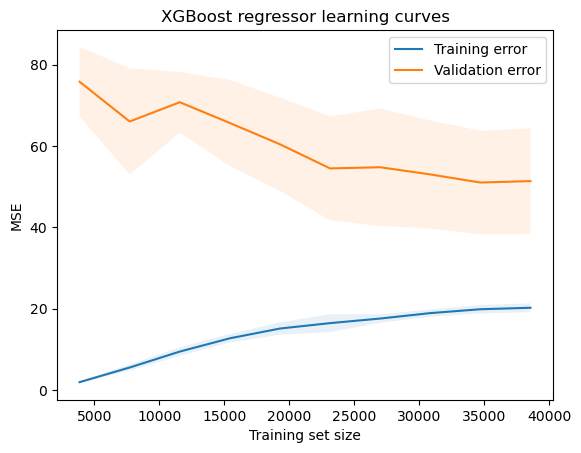

In [51]:
from sklearn.model_selection import learning_curve
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# create an XGBoost regressor object
xgb_reg = xgb.XGBRegressor()

# define the training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(xgb_reg, X_train, y_train, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# calculate the mean and standard deviation of the scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot the learning curves
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Validation error')

# add error bars
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)

# add labels and legend
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.title('XGBoost regressor learning curves')
plt.legend()

plt.show()


In [38]:

    
    # plot training history
    epochs = len(model.history['train']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, model.history['train']['rmse'], label='Train')
    ax.plot(x_axis, model.history['val']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title(f'XGBoost RMSE (fold {fold + 1})')
    plt.show()


"""test_dmatrix = xgb.DMatrix(X_test, label=y_test)

for fold, model in enumerate(models):
    y_pred = model.predict(test_dmatrix)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Fold {fold + 1} test MSE: {mse:.4f}')"""


Fold 1
[09:14:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:6.60048	val-rmse:6.56070
[50]	train-rmse:5.09549	val-rmse:5.52739
[100]	train-rmse:4.58623	val-rmse:5.27482
[150]	train-rmse:4.13334	val-rmse:5.11485
[200]	train-rmse:3.82276	val-rmse:5.01899
[250]	train-rmse:3.52379	val-rmse:4.95670
[300]	train-rmse:3.24536	val-rmse:4.89980
[350]	train-rmse:3.01724	val-rmse:4.86454
[400]	train-rmse:2.80678	val-rmse:4.83280
[450]	train-rmse:2.63774	val-rmse:4.80736
[500]	train-rmse:2.46376	val-rmse:4.79711
[539]	train-rmse:2.35907	val-rmse:4.79068


AttributeError: 'Booster' object has no attribute 'history'

In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'gpu_id': '0,1',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 100
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = []
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f'Fold {fold + 1}')
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dval, 'val')],
        callbacks=[xgb.callback.record_evaluation()],
        verbose_eval=50
    )
    
    models.append(model)
    
    # plot training history
    evals_result = model.eval(dtrain=dtrain, evals=[(dtrain, 'train'), (dval, 'val')])
    train_rmse = evals_result['train']['rmse']
    val_rmse = evals_result['val']['rmse']
    epochs = len(train_rmse)
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, train_rmse, label='Train')
    ax.plot(x_axis, val_rmse, label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title(f'XGBoost RMSE (fold {fold + 1})')
    plt.show()

test_data = pd.read_csv('your_test_data.csv')
X_test = test_data.drop(columns=['target_column'])
y_test = test_data['target_column']

test_dmatrix = xgb.DMatrix(X_test, label=y_test)

for fold, model in enumerate(models):
    y_pred = model.predict(test_dmatrix)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Fold {fold + 1} test MSE: {mse:.4f}')


Fold 1


AttributeError: module 'xgboost.callback' has no attribute 'record_evaluation'